# TODO:

- ordenar no tempo

# Nubank Data Challenge
## Risk Credit (default)

Análise Exploratória
Como dito, a inadimplência é o aspecto mais sensível quando se fala em crédito. Faça três visualizações que explorem a inadimplência na base fornecida.

Faça uma análise dos casos de fraude. Qual a relação deles com os casos de inadimplência?

Analisando a distribuição do volume de compras em 3 meses dos clientes (variável pv_3m), você diria que ela segue uma distribuição normal? Há algo de estranho nela? Se sim, qual seria a justificativa ou hipótese para tal?

In [2]:
# TODO: ordenar os imports
# TODO: install xgboost, lightgbm, catboost
import numpy as np
import pandas as pd
import missingno as msno
import gc
from IPython.display import set_matplotlib_formats
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.interactiveshell import InteractiveShell
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import LabelEncoder

InteractiveShell.ast_node_interactivity = "all"
pd.options.display.max_columns = None

In [1]:
# Some defines about plot
%matplotlib inline

set_matplotlib_formats('pdf', 'png')
pd.options.display.float_format = '{:.2f}'.format
rc={'savefig.dpi': 75, 'figure.autolayout': False, 'figure.figsize': [12, 8], 'axes.labelsize': 18,\
   'axes.titlesize': 18, 'font.size': 18, 'lines.linewidth': 2.0, 'lines.markersize': 8, 'legend.fontsize': 16,\
   'xtick.labelsize': 16, 'ytick.labelsize': 16}

sns.set(style='dark',rc=rc)

default_color = '#56B4E9'
colormap = plt.cm.cool

NameError: name 'set_matplotlib_formats' is not defined

## Loading and Inspecting the dataset

### Loading

Let's load the datasets and do some basic transformations:
- separate column `ids` on test
- remove `target_fraud` which isn't our target for now
- rename `target_default` to `target`, just for semantic

TODO: Verificar a necesidade de explicar que já temos conhecimento dessa variável pela descrição do dataset

In [5]:
path = '../../data/raw/'

train_df = pd.read_csv(path + 'acquisition_train.csv')
train_df.drop('target_fraud', axis=1, inplace=True)
train_df.rename({'target_default': 'target'}, axis=1, inplace=True)

test_df = pd.read_csv(path + 'acquisition_test.csv')
ids_test = test_df['ids'].values

In [7]:
# latlong
# import ast
# ast.literal_eval(train_df

True

### Basic Inspecting

In [4]:
train_df.shape
test_df.shape

train_df.info()
train_df.describe()

train_df.head()
train_df.tail()

(45000, 42)

(19592, 41)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 42 columns):
ids                                                 45000 non-null object
target                                              41741 non-null object
score_1                                             44438 non-null object
score_2                                             44438 non-null object
score_3                                             44438 non-null float64
score_4                                             45000 non-null float64
score_5                                             45000 non-null float64
score_6                                             45000 non-null float64
risk_rate                                           44438 non-null float64
last_amount_borrowed                                15044 non-null float64
last_borrowed_in_months                             15044 non-null float64
credit_limit                                        31200 non-null flo

,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,last_borrowed_in_months,credit_limit,income,ok_since,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,application_time_in_funnel,external_data_provider_credit_checks_last_2_year,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_fraud_score,reported_income,shipping_zip_code
count,44438.00,45000.00,45000.00,45000.00,44438.00,15044.00,15044.00,31200.00,44438.00,18455.00,44303.00,44426.00,44438.00,33456.00,45000.00,22372.00,45000.00,29876.00,42767.00,45000.00,45000.00,45000.00
mean,347.98,100.01,0.50,99.93,0.30,13782.34,41.76,34381.95,71607.39,35.07,0.08,0.00,10.70,11.07,247.54,0.00,1.50,0.50,12.53,500.40,inf,33923.51
std,110.43,3.18,0.29,10.02,0.10,8077.57,10.25,36586.98,51858.97,21.66,0.27,0.08,4.59,4.60,146.12,0.00,1.11,0.50,126.53,287.97,nan,12692.41
min,0.00,86.19,0.00,60.66,0.00,1005.18,36.00,0.00,4821.18,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-999.00,0.00,403.00,12001.00
25%,270.00,97.87,0.25,93.20,0.22,7519.50,36.00,10000.00,45010.78,17.00,0.00,0.00,7.00,8.00,120.00,0.00,1.00,0.00,11.00,252.00,50948.25,22937.00
50%,340.00,100.02,0.50,99.97,0.29,12023.47,36.00,25647.00,61266.76,32.00,0.00,0.00,10.00,10.00,248.00,0.00,2.00,1.00,27.00,503.00,101779.00,33896.00
75%,420.00,102.14,0.75,106.64,0.36,19220.27,36.00,47086.75,86019.23,50.00,0.00,0.00,13.00,14.00,375.00,0.00,2.00,1.00,43.00,747.00,151337.25,44910.00
max,990.00,113.98,1.00,142.19,0.90,35059.60,60.00,448269.00,5000027.83,141.00,5.00,5.00,49.00,49.00,500.00,0.00,3.00,1.00,59.00,1000.00,inf,56000.00


,ids,target,score_1,score_2,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,last_borrowed_in_months,credit_limit,reason,income,facebook_profile,state,zip,channel,job_name,real_state,ok_since,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,application_time_applied,application_time_in_funnel,email,external_data_provider_credit_checks_last_2_year,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_first_name,external_data_provider_fraud_score,lat_lon,marketing_channel,profile_phone_number,reported_income,shipping_state,shipping_zip_code,profile_tags,user_agent
0,343b7e7b-2cf8-e508-b8fd-0a0285af30aa,False,1Rk8w4Ucd5yR3KcqZzLdow==,IOVu8au3ISbo6+zmfnYwMg==,350.00,101.80,0.26,108.43,0.40,25033.92,36.00,0.00,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,65014.12,True,sjJbkqJS7cXalHLBFA+EOQ==,Ernn+uVXCMq/6ARrBCcd+A==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,N5/CE7lSkAfB04hVFFwllw==,nan,0.00,0.00,18.00,18.00,07:52:34,444,outlook.com,nan,2,0.00,51.00,leidelaura,645,"(-29.151545708122246, -51.1386461804385)",Invite-email,514-9840782,57849.00,BR-MT,17528,"{'tags': ['n19', 'n8']}",Mozilla/5.0 (Linux; Android 6.0.1; SGP771 Buil...
1,bc2c7502-bbad-0f8c-39c3-94e881967124,False,DGCQep2AE5QRkNCshIAlFQ==,SaamrHMo23l/3TwXOWgVzw==,370.00,97.06,0.94,92.00,0.24,nan,nan,39726.00,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,100018.91,False,xsd3ZdsI3356I3xMxZeiqQ==,rlWIXTBO+VOa34+SpGyhlQ==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,N5/CE7lSkAfB04hVFFwllw==,50.00,0.00,0.00,14.00,14.00,02:34:29,346,gmail.com,0.00,1,0.00,17.00,diocezio,243,"(-19.687710705798963, -47.94151536525154)",Radio-commercial,251-3659293,4902.00,BR-RS,40933,"{'tags': ['n6', 'n7', 'nim']}",Mozilla/5.0 (Linux; Android 5.0.2; SAMSUNG SM-...
2,669630dd-2e6a-0396-84bf-455e5009c922,True,DGCQep2AE5QRkNCshIAlFQ==,Fv28Bz0YRTVAT5kl1bAV6g==,360.00,100.03,0.35,112.89,0.29,7207.92,36.00,nan,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,65023.65,NaN,Ygq6MsM98oC8yceExr69Ig==,PjTIDfJsK0DKL9fO7vuW2g==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,n+xK9CfX0bCn77lClTWviw==,nan,0.00,0.00,10.00,nan,00:60:02,6,gmail.com,nan,2,nan,9.00,veralucia,65,"(-28.748023890412284, -51.867279334353995)",Waiting-list,230-6097993,163679.00,BR-RR,50985,"{'tags': ['n0', 'n17', 'nim', 'da']}",Mozilla/5.0 (Linux; Android 6.0.1; SGP771 Buil...
3,d235609e-b6cb-0ccc-a329-d4f12e7ebdc1,False,1Rk8w4Ucd5yR3KcqZzLdow==,dCm9hFKfdRm7ej3jW+gyxw==,510.00,101.60,0.99,94.90,0.32,nan,nan,54591.00,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,68830.01,False,KET/Pmr6rHp1RJ/P9ymztw==,Cc/kWDLQH3dpHv5HU+pLVA==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiE56f...,n+xK9CfX0bCn77lClTWviw==,nan,1.00,0.00,19.00,19.00,11:20:49,406,spgov.com,nan,3,nan,38.00,venice,815,"(-17.520650158450454, -39.75801139933186)",Waiting-list,261-3543751,1086.00,BR-RN,37825,{'tags': ['n4']},Mozilla/5.0 (Linux; Android 6.0; HTC One X10 B...
4,9e0eb880-e8f4-3faa-67d8-f5cdd2b3932b,False,8k8UDR4Yx0qasAjkGrUZLw==,+CxEO4w7jv3QPI/BQbyqAA==,500.00,98.47,0.53,118.13,0.18,nan,nan,nan,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,60011.29,True,xsd3ZdsI3356I3xMxZeiqQ==,i036nmJ7rfxo+3EvCD7Jnw==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,n+xK9CfX0bCn77lClTWviw==,nan,0.00,0.00,11.00,nan,13:39:03,240,gmail.com,0.00,2,1.00,46.00,darzisa,320,"(-16.574259446978008, -39.90990074785962)",Invite-email,102-3660162,198618.00,BR-MT,52827,"{'tags': ['pro+aty', 'n19', 'da', 'b19']}",Mozilla/5.0 (Linux; Android 7.0; Pixel C Build...


,ids,target,score_1,score_2,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,last_borrowed_in_months,credit_limit,reason,income,facebook_profile,state,zip,channel,job_name,real_state,ok_since,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,application_time_applied,application_time_in_funnel,email,external_data_provider_credit_checks_last_2_year,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_first_name,external_data_provider_fraud_score,lat_lon,marketing_channel,profile_phone_number,reported_income,shipping_state,shipping_zip_code,profile_tags,user_agent
44995,696cb747-1159-0a29-6731-8c52c6c42f5d,False,DGCQep2AE5QRkNCshIAlFQ==,SaamrHMo23l/3TwXOWgVzw==,280.00,96.38,0.42,103.67,0.17,14766.42,36.00,10627.00,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,100013.24,False,x6Gw/1I8t3KPgT6s82Kodg==,Hfh28TzqkRno6rOU/tjy6Q==,NCqL3QBx0pscDnx3ixKwXg==,NaN,N5/CE7lSkAfB04hVFFwllw==,37.00,0.00,0.00,7.00,7.00,13:27:39,72,hotmail.com,0.00,2,1.00,7.00,ornilza,730,"(-22.486891256430695, -44.909010639017616)",Facebook,768-5074915,73417.00,BR-GO,52148,"{'tags': ['n1', 'n7', 'n4', 'n0']}",Mozilla/5.0 (Linux; Android 6.0.1; SM-G920V Bu...
44996,92cd9b1a-9a8e-43ad-5d96-8e999128b472,False,smzX0nxh5QlePvtVf6EAeg==,vJyc9xom9v7hwFMPTIpmKw==,370.00,96.12,0.69,97.98,0.27,nan,nan,36262.00,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,95026.69,False,bwNrC22VlFOFk6/nEHQc6A==,vYKZVZfAwOMRjE0QGAYvbA==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,N5/CE7lSkAfB04hVFFwllw==,nan,0.00,0.00,16.00,16.00,22:50:49,51,gmail.com,nan,1,nan,1.00,deisilu,28,"(-12.881449687799003, -46.43545330884514)",Waiting-list,772-3517810,26246.00,BR-RO,46084,"{'tags': ['n11', 'n5', 'n12']}",Mozilla/5.0 (X11; CrOS x86_64 8172.45.0) Apple...
44997,febdd174-cf18-0be1-feb8-38399dd67d9e,False,e4NYDor1NOw6XKGE60AWFw==,ky19q4V1ZqgL3jnHX0wKDw==,280.00,102.38,0.53,93.69,0.30,nan,nan,0.00,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,106020.90,NaN,xsd3ZdsI3356I3xMxZeiqQ==,Kihc6OKBTIHsGwCQy2Vruw==,NCqL3QBx0pscDnx3ixKwXg==,NaN,nSpvDsIsslUaX6GE6m6eQA==,7.00,0.00,0.00,6.00,6.00,09:60:49,476,gmail.com,nan,2,1.00,27.00,elayne,940,"(-23.888982131800983, -50.645313285616645)",Waiting-list,334-9885724,101252.00,BR-SP,30570,"{'tags': ['dfa', 'c55', 'pro+aty']}",Mozilla/5.0 (Linux; Android 5.0.2; LG-V410/V41...
44998,a0a5a872-6165-b939-b711-37d045a0b5a8,True,smzX0nxh5QlePvtVf6EAeg==,6J1ZMTzN5GKHXnhM4J1JbA==,240.00,100.48,0.21,86.76,0.37,nan,nan,0.00,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,185018.07,True,xsd3ZdsI3356I3xMxZeiqQ==,Kihc6OKBTIHsGwCQy2Vruw==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,N5/CE7lSkAfB04hVFFwllw==,53.00,0.00,0.00,10.00,10.00,02:18:51,35,gmail.com,0.00,0,1.00,2.00,hidelburgo,459,"(-5.14769885524928, -37.98386842511541)",Instagram,238-9568414,129844.00,BR-SP,12742,"{'tags': ['n9', 'n2']}",Mozilla/5.0 (Linux; Android 5.0.2; SAMSUNG SM-...
44999,a7504e93-123a-f965-70c6-ab01a0d475f7,False,8k8UDR4Yx0qasAjkGrUZLw==,wkeCdGeu5sEv4/fjwR0aDg==,530.00,101.10,0.01,97.36,0.31,4226.74,36.00,17942.00,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,34013.65,NaN,BB/zpwTH+8GCIVHlhzOU1Q==,8fTg1YyyuslJ5OATAWj5Ww==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,n+xK9CfX0bCn77lClTWviw==,nan,0.00,0.00,10.00,10.00,15:01:57,414,hotmail.com,0.00,1,nan,45.00,genny,781,"(-23.13900985246712, -52.29465769715389)",Facebook,296-8101743,112766.00,BR-MT,41693,"{'tags': ['dfa', 'c55', 'pro+aty', 'n8', 'n4']}",Mozilla/5.0 (iPhone; CPU iPhone OS 11_0 like M...


### Target Analisys

We can see above there is some missing values on target column. let's take a closer look...

Total: 45000 - Null: 3259 - Not-Null: 41741 - (7.24% Null)


False    35080
True      6661
Name: target, dtype: int64

Text(-0.15,32080,'35080 - (77.96%)')

Text(0.85,3661,'6661 - (14.80%)')

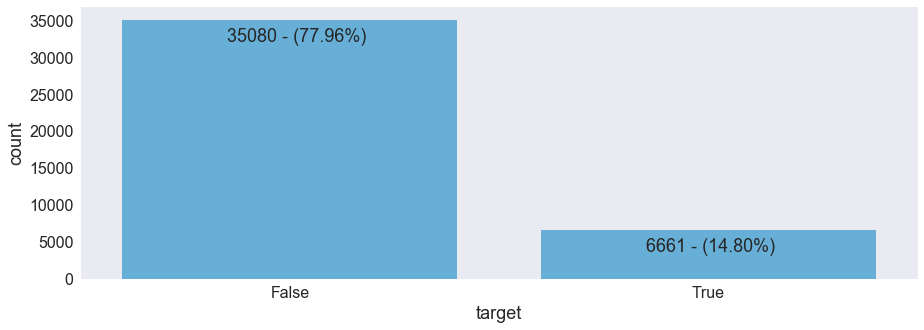

In [5]:
# TODO: Extrair para função
target_total = len(train_df['target'])
target_null = train_df[train_df['target'].isnull()]['ids'].count()
target_not_null = target_total - target_null
target_null_percent = target_null / target_total * 100

print('Total: {} - Null: {} - Not-Null: {} - ({:.2f}% Null)'.format(target_total, 
                                                                    target_null, 
                                                                    target_not_null, 
                                                                    target_null_percent))

train_df['target'].value_counts()

plt.figure(figsize=(15,5))
ax = sns.countplot('target', data=train_df, color=default_color)
for p in ax.patches:
    count = p.get_height()
    percent = 100 * count / len(train_df['target'])
    ax.annotate('{} - ({:.2f}%)'.format(count, percent), 
                (p.get_x()+0.25, p.get_height()-3000))

#### Drop missing in target

Missing values in our target variable represents 7,24%. Let's drop.

In [6]:
train_df.dropna(subset=['target'], inplace=True)
train_df.shape
train_df.info()

(41741, 42)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41741 entries, 0 to 44999
Data columns (total 42 columns):
ids                                                 41741 non-null object
target                                              41741 non-null object
score_1                                             41741 non-null object
score_2                                             41741 non-null object
score_3                                             41741 non-null float64
score_4                                             41741 non-null float64
score_5                                             41741 non-null float64
score_6                                             41741 non-null float64
risk_rate                                           41741 non-null float64
last_amount_borrowed                                14133 non-null float64
last_borrowed_in_months                             14133 non-null float64
credit_limit                                        28632 non-null flo

### Check unvaluable columns

The columns listed below 
- channel - only one (NCqL3QBx0pscDnx3ixKwXg==)
- external_data_provider_first_name
- profile_phone_number
- profile_tags
- user_agent

### Remove unknown columns

We need to remove all unknown columns at acquisition time

TODO: Verificar as colunas:
- risk_rate

In [7]:
unknown = ['credit_limit']
for col in unknown:
    train_df.drop(col, axis=1, inplace=True)
    test_df.drop(col, axis=1, inplace=True)

### Check consistency values

Valores negativos por exemplo

### Remove ids

TODO: verificar essa parte de separar a variável

Now we have to separate the column `ids` to create submission file at end and drop this column

In [8]:
train_df.drop('ids', axis=1, inplace=True)
test_df.drop('ids', axis=1, inplace=True)

### Other Missing values

As we can see, there is missing values in our target column

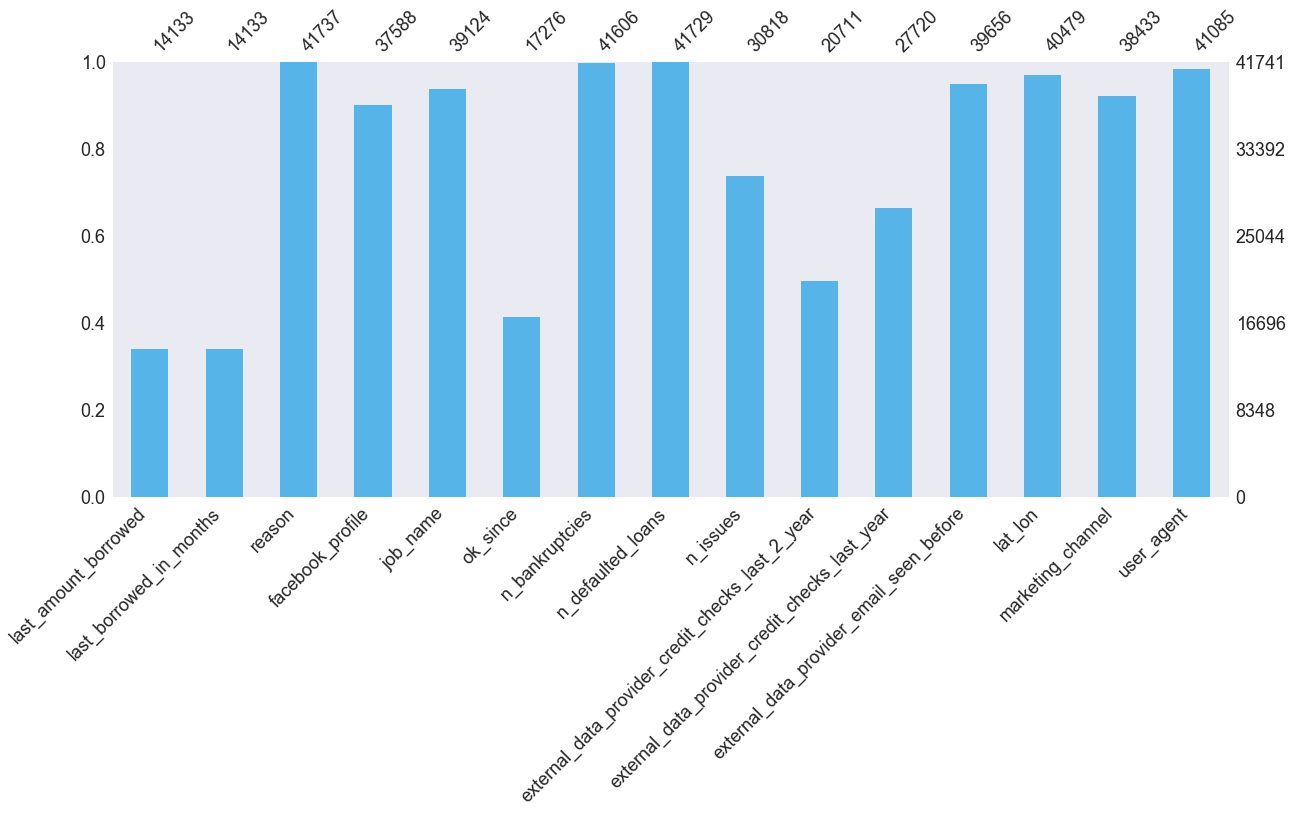

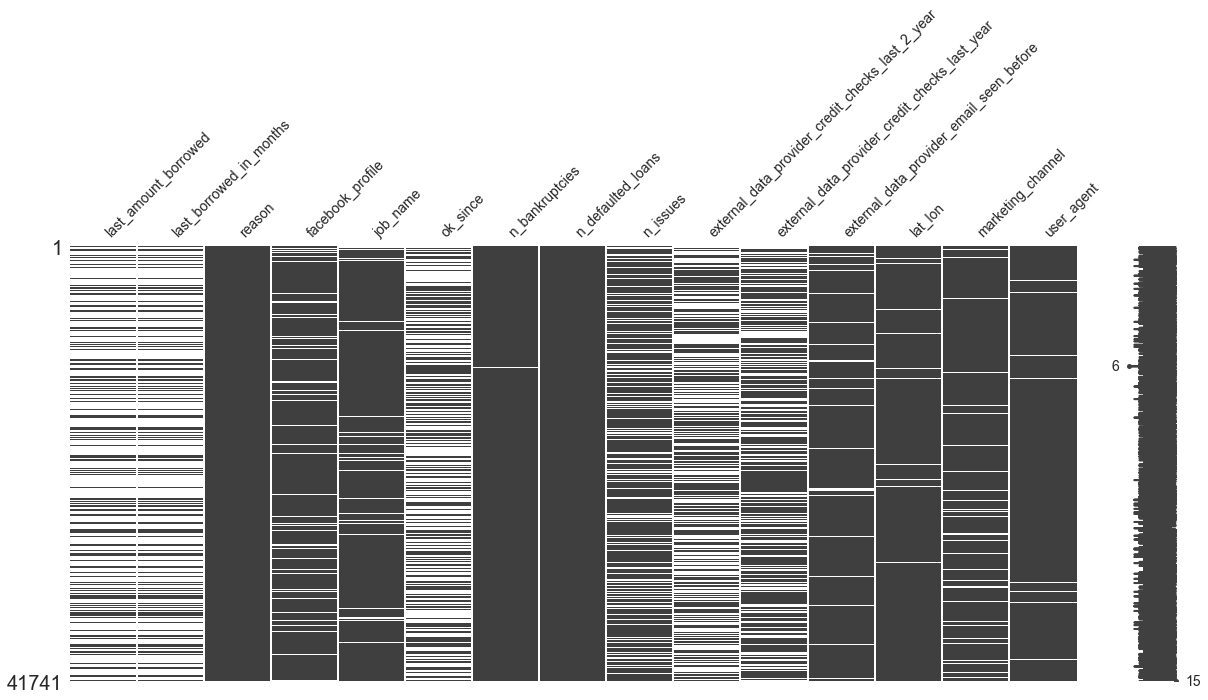

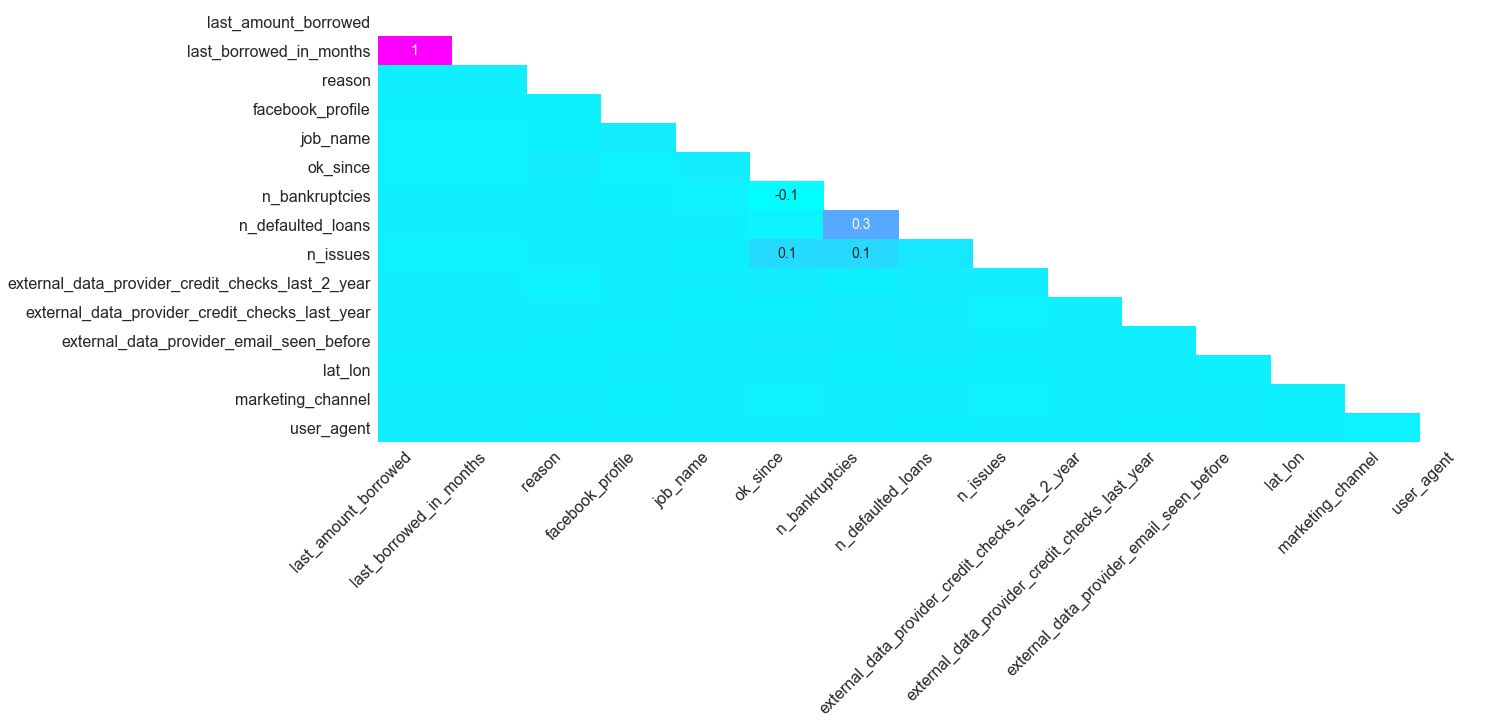

In [9]:
missing_value_columns = train_df.columns[train_df.isnull().any()].tolist()
train_df_missing = train_df[missing_value_columns]

msno.bar(train_df_missing,figsize=(20,8),color=default_color,fontsize=18,labels=True)
msno.matrix(train_df_missing,figsize=(20,8),fontsize=14)
msno.heatmap(train_df_missing,figsize=(20,8),cmap=colormap)

### Encoding

As a first approach, let's label encode all string variables

In [10]:
def encode(df, columns: list) -> pd.DataFrame:
        """Summary

        Args:
            columns (list): Description

        Returns:
            pd.DataFrame: Description
        """
        l_e = LabelEncoder()
        for col in columns:
            df[col].fillna('-1', inplace=True)
            df[col] = l_e.fit_transform(df[col])
        return df

In [11]:
encoding_cols = ['score_1', 'score_2', 'reason',
                 'state', 'zip', 'channel', 'job_name', 'real_state', 
                 'application_time_applied', 'email', 'external_data_provider_first_name', 
                 'lat_lon', 'marketing_channel', 'profile_phone_number', 'shipping_state', 
                 'shipping_zip_code', 'profile_tags', 'user_agent']
train_df = encode(train_df, encoding_cols)
train_df.head()

,target,score_1,score_2,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,last_borrowed_in_months,reason,income,facebook_profile,state,zip,channel,job_name,real_state,ok_since,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,application_time_applied,application_time_in_funnel,email,external_data_provider_credit_checks_last_2_year,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_first_name,external_data_provider_fraud_score,lat_lon,marketing_channel,profile_phone_number,reported_income,shipping_state,shipping_zip_code,profile_tags,user_agent
0,False,0,10,350.00,101.80,0.26,108.43,0.40,25033.92,36.00,7981,65014.12,True,44,208,0,25660,1,nan,0.00,0.00,18.00,18.00,11345,444,4,nan,2,0.00,51.00,18909,645,14444,3,25853,57849.00,12,3393,16027,87
1,False,3,16,370.00,97.06,0.94,92.00,0.24,nan,nan,12061,100018.91,False,47,710,0,3865,1,50.00,0.00,0.00,14.00,14.00,3704,346,0,0.00,1,0.00,17.00,7427,243,6716,6,10722,4902.00,20,17831,20134,34
2,True,3,9,360.00,100.03,0.35,112.89,0.29,7207.92,36.00,4071,65023.65,NaN,32,350,0,25888,3,nan,0.00,0.00,10.00,nan,1356,6,0,nan,2,nan,9.00,29469,65,14320,8,9284,163679.00,19,23954,6528,82
3,False,0,21,510.00,101.60,0.99,94.90,0.32,nan,nan,10425,68830.01,False,23,183,0,79,3,nan,1.00,0.00,19.00,19.00,15991,406,5,nan,3,nan,38.00,29444,815,4911,8,11426,1086.00,17,15930,18654,124
4,False,2,1,500.00,98.47,0.53,118.13,0.18,nan,nan,5821,60011.29,True,47,578,0,24488,3,nan,0.00,0.00,11.00,nan,18925,240,0,0.00,2,1.00,46.00,6293,320,4360,3,178,198618.00,12,25071,24158,143


## Creating a baseline

Let's run a XGBoost with a minimal transformation in our dataset

In [12]:
# Fill nulls with -1
train_df.replace([np.inf, -np.inf], np.nan)
test_df.replace([np.inf, -np.inf], np.nan)
train_df.fillna(-1, inplace=True)
test_df.fillna(-1, inplace=True)

train_df = train_df.reset_index()

train_df.head()

,target,score_1,score_2,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,last_borrowed_in_months,reason,income,facebook_profile,state,zip,channel,job_name,real_state,ok_since,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,application_time_applied,application_time_in_funnel,email,external_data_provider_credit_checks_last_2_year,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_first_name,external_data_provider_fraud_score,lat_lon,marketing_channel,profile_phone_number,reported_income,shipping_state,shipping_zip_code,profile_tags,user_agent
0,False,0,10,350.00,101.80,0.26,108.43,0.40,25033.92,36.00,7981,65014.12,True,44,208,0,25660,1,nan,0.00,0.00,18.00,18.00,11345,444,4,nan,2,0.00,51.00,18909,645,14444,3,25853,57849.00,12,3393,16027,87
1,False,3,16,370.00,97.06,0.94,92.00,0.24,nan,nan,12061,100018.91,False,47,710,0,3865,1,50.00,0.00,0.00,14.00,14.00,3704,346,0,0.00,1,0.00,17.00,7427,243,6716,6,10722,4902.00,20,17831,20134,34
2,True,3,9,360.00,100.03,0.35,112.89,0.29,7207.92,36.00,4071,65023.65,NaN,32,350,0,25888,3,nan,0.00,0.00,10.00,nan,1356,6,0,nan,2,nan,9.00,29469,65,14320,8,9284,163679.00,19,23954,6528,82
3,False,0,21,510.00,101.60,0.99,94.90,0.32,nan,nan,10425,68830.01,False,23,183,0,79,3,nan,1.00,0.00,19.00,19.00,15991,406,5,nan,3,nan,38.00,29444,815,4911,8,11426,1086.00,17,15930,18654,124
4,False,2,1,500.00,98.47,0.53,118.13,0.18,nan,nan,5821,60011.29,True,47,578,0,24488,3,nan,0.00,0.00,11.00,nan,18925,240,0,0.00,2,1.00,46.00,6293,320,4360,3,178,198618.00,12,25071,24158,143
5,False,2,1,300.00,101.84,0.92,90.71,0.44,nan,nan,6183,75024.28,False,22,609,0,29170,1,nan,0.00,0.00,9.00,9.00,7872,169,0,nan,2,1.00,21.00,28010,811,18572,9,41001,160198.00,23,26567,3243,69
6,False,0,21,250.00,98.96,0.90,108.61,0.43,nan,nan,11913,49234.65,False,47,71,0,4898,3,nan,0.00,0.00,8.00,nan,11934,74,0,0.00,2,0.00,16.00,30254,527,11253,7,6178,132928.00,23,21762,17760,288
7,False,3,9,330.00,100.34,0.49,115.95,0.33,nan,nan,11384,80024.60,True,41,607,0,8002,1,nan,0.00,0.00,7.00,7.00,24493,184,4,0.00,3,0.00,37.00,24049,415,20037,8,25257,8658.00,0,14903,12107,261
8,False,1,30,510.00,95.20,0.56,94.66,0.33,5019.53,60.00,5695,31019.09,True,47,258,0,29684,3,nan,0.00,0.00,8.00,nan,20753,420,5,0.00,0,nan,6.00,5492,793,9136,9,38988,82272.00,11,22910,11536,10
9,True,4,19,390.00,97.61,0.44,102.91,0.36,nan,nan,9522,45026.26,False,27,218,0,14549,1,nan,0.00,0.00,8.00,8.00,6877,7,2,0.00,2,0.00,nan,9394,703,4391,1,2327,96889.00,15,20514,22716,235


,score_1,score_2,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,last_borrowed_in_months,reason,income,facebook_profile,state,zip,channel,job_name,real_state,ok_since,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,application_time_applied,application_time_in_funnel,email,external_data_provider_credit_checks_last_2_year,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_first_name,external_data_provider_fraud_score,lat_lon,marketing_channel,profile_phone_number,reported_income,shipping_state,shipping_zip_code,profile_tags,user_agent
0,smzX0nxh5QlePvtVf6EAeg==,tHpS8e9F8d9zg3iOQM9tsA==,710.00,104.17,0.66,123.02,0.43,nan,nan,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,59869.05,True,xsd3ZdsI3356I3xMxZeiqQ==,i036nmJ7rfxo+3EvCD7Jnw==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,n+xK9CfX0bCn77lClTWviw==,14.00,1.00,0.00,9.00,9.00,24:10:59,407,spgov.com,nan,0,1.00,2.00,roseclair,712,"(-23.465879688096386, -51.92295514611923)",Instagram,610-2157103,160236.00,BR-MA,43388,"{'tags': ['n4', 'n3', 'n12', 'n19']}",Mozilla/5.0 (Linux; Android 5.0.2; LG-V410/V41...
1,4DLlLW62jReXaqbPaHp1vQ==,tQUTfUyeuGkhRotd+6WjVg==,120.00,100.43,0.14,120.13,0.15,nan,nan,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,46011.12,False,GW2VZ3dN3OGHSjQ6JkfqQw==,coa2oOrpjxnQl4iyM7dTpQ==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,N5/CE7lSkAfB04hVFFwllw==,nan,0.00,0.00,5.00,nan,24:19:17,11,hotmail.com,0.00,2,0.00,10.00,helionice,1,NaN,Instagram,157-9192132,46782.00,BR-AM,15536,{'tags': ['n7']},Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...
2,DGCQep2AE5QRkNCshIAlFQ==,Fv28Bz0YRTVAT5kl1bAV6g==,280.00,95.40,0.59,101.66,0.24,11539.08,36.00,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,85022.96,True,BB/zpwTH+8GCIVHlhzOU1Q==,exaXk+hI3vMFsjz87ctTUg==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,N5/CE7lSkAfB04hVFFwllw==,43.00,0.00,0.00,19.00,19.00,15:08:08,316,gmail.com,0.00,3,0.00,36.00,cleron,917,"(1.1239729311649262, -53.11108971396174)",Website,138-4518726,23762.00,BR-MA,23804,"{'tags': ['b19', 'da', 'n5', 'n0']}",Mozilla/5.0 (Linux; Android 6.0; HTC One X10 B...
3,DGCQep2AE5QRkNCshIAlFQ==,RO7MTL+j4PH2gNzbhNTq/A==,240.00,100.98,0.59,101.72,0.20,nan,nan,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,121030.61,NaN,ygE7OTdsxRMLeXMa0EZwZw==,4Hmfy977853uyP1D2rxg0A==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,N5/CE7lSkAfB04hVFFwllw==,nan,0.00,0.00,9.00,9.00,10:01:03,120,hotmail.com,nan,0,1.00,47.00,licerio,128,"(-4.032314147616197, -41.03351578727996)",Instagram,442-7405767,139125.00,BR-GO,22206,"{'tags': ['n19', 'n8', 'n6', 'pro+aty', 'n0']}",Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...
4,8k8UDR4Yx0qasAjkGrUZLw==,wkeCdGeu5sEv4/fjwR0aDg==,430.00,101.29,0.69,114.95,0.61,nan,nan,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,80019.03,False,xsd3ZdsI3356I3xMxZeiqQ==,vjsYtmgFNg/8e4C3S58AiA==,NCqL3QBx0pscDnx3ixKwXg==,NaN,N5/CE7lSkAfB04hVFFwllw==,nan,0.00,0.00,10.00,nan,03:07:48,347,hotmail.com,0.00,0,nan,6.00,beatris,776,"(-4.511307141215452, -37.744723570998374)",NaN,105-3221582,68966.00,BR-SC,23874,"{'tags': ['c55', 'pro+aty', 'b19', 'b19', 'b19']}",Mozilla/5.0 (Linux; Android 5.0.2; LG-V410/V41...
5,1Rk8w4Ucd5yR3KcqZzLdow==,dCm9hFKfdRm7ej3jW+gyxw==,290.00,97.39,0.39,90.79,0.33,nan,nan,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,110039.83,True,7bX4XFXmYqoMspxup0CrKA==,27DtYF3F+XRgnXqsIGlx/A==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,n+xK9CfX0bCn77lClTWviw==,nan,0.00,0.00,7.00,7.00,18:07:16,21,hotmail.com,0.00,3,1.00,22.00,ciria,426,"(-10.79434797256168, -37.23584058871652)",Invite-email,211-6125187,46371.00,BR-RS,31529,"{'tags': ['n4', 'n15', 'n9', 'n10']}",Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...
6,DGCQep2AE5QRkNCshIAlFQ==,SaamrHMo23l/3TwXOWgVzw==,470.00,103.52

,index,target,score_1,score_2,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,last_borrowed_in_months,reason,income,facebook_profile,state,zip,channel,job_name,real_state,ok_since,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,application_time_applied,application_time_in_funnel,email,external_data_provider_credit_checks_last_2_year,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_first_name,external_data_provider_fraud_score,lat_lon,marketing_channel,profile_phone_number,reported_income,shipping_state,shipping_zip_code,profile_tags,user_agent
0,0,False,0,10,350.00,101.80,0.26,108.43,0.40,25033.92,36.00,7981,65014.12,True,44,208,0,25660,1,-1.00,0.00,0.00,18.00,18.00,11345,444,4,-1.00,2,0.00,51.00,18909,645,14444,3,25853,57849.00,12,3393,16027,87
1,1,False,3,16,370.00,97.06,0.94,92.00,0.24,-1.00,-1.00,12061,100018.91,False,47,710,0,3865,1,50.00,0.00,0.00,14.00,14.00,3704,346,0,0.00,1,0.00,17.00,7427,243,6716,6,10722,4902.00,20,17831,20134,34
2,2,True,3,9,360.00,100.03,0.35,112.89,0.29,7207.92,36.00,4071,65023.65,-1,32,350,0,25888,3,-1.00,0.00,0.00,10.00,-1.00,1356,6,0,-1.00,2,-1.00,9.00,29469,65,14320,8,9284,163679.00,19,23954,6528,82
3,3,False,0,21,510.00,101.60,0.99,94.90,0.32,-1.00,-1.00,10425,68830.01,False,23,183,0,79,3,-1.00,1.00,0.00,19.00,19.00,15991,406,5,-1.00,3,-1.00,38.00,29444,815,4911,8,11426,1086.00,17,15930,18654,124
4,4,False,2,1,500.00,98.47,0.53,118.13,0.18,-1.00,-1.00,5821,60011.29,True,47,578,0,24488,3,-1.00,0.00,0.00,11.00,-1.00,18925,240,0,0.00,2,1.00,46.00,6293,320,4360,3,178,198618.00,12,25071,24158,143


In [13]:
np.where(train_df.values >= np.finfo(np.float64).max)

(array([ 3470,  3710,  4288,  5046,  5536,  5924,  6601,  6907,  7026,
         7552,  8632,  8905,  9236, 11146, 11593, 12369, 12591, 12812,
        13075, 13509, 14788, 16703, 16952, 17860, 19017, 19226, 19355,
        19697, 19816, 19944, 20459, 20883, 21856, 22520, 23214, 24568,
        24936, 27043, 27820, 27929, 28612, 28967, 29510, 29673, 29694,
        30202, 30367, 31073, 31996, 32903, 33179, 33682, 35810, 37566,
        38754, 38949, 39112, 39303, 39324, 39415, 40125, 40204, 40616,
        40652, 40936, 41102]),
 array([36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36,
        36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36,
        36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36,
        36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36]))

In [14]:
# np.any(np.isnan(train_df))
# np.isfinite(train_df).all()

In [15]:
X = train_df.drop('target',axis=1)
y = train_df['target']

In [21]:
def cross_val_model(X,y, model, n_splits=3):
    X = np.array(X.astype('float32'))
    y = np.array(y.astype('float32'))


    folds = list(StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=2017).split(X, y))

    for j, (train_idx, test_idx) in enumerate(folds):
        X_train = X[train_idx]
        y_train = y[train_idx]
        X_holdout = X[test_idx]
        y_holdout = y[test_idx]

        print ("Fit %s fold %d" % (str(model).split('(')[0], j+1))
        model.fit(X_train, y_train)
        cross_score = cross_val_score(model, X_holdout, y_holdout, cv=3, scoring='roc_auc')
        print("    cross_score: %.5f" % cross_score.mean())

### Random Forest

TODO: com problema

In [22]:
# RandomForest params
rf_params = {}
rf_params['n_estimators'] = 200
rf_params['max_depth'] = 6
rf_params['min_samples_split'] = 70
rf_params['min_samples_leaf'] = 30

In [23]:
rf_model = RandomForestClassifier(**rf_params)

In [24]:
cross_val_model(X, y, rf_model)

Fit RandomForestClassifier fold 1


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

### XGBoost

In [19]:
# XGBoost params
xgb_params = {}
xgb_params['learning_rate'] = 0.02
xgb_params['n_estimators'] = 1000
xgb_params['max_depth'] = 4
xgb_params['subsample'] = 0.9
xgb_params['colsample_bytree'] = 0.9

In [20]:
XGB_model = XGBClassifier(**xgb_params)

In [44]:
cross_val_model(X, y, XGB_model)

Fit XGBClassifier fold 1
    cross_score: 0.71473
Fit XGBClassifier fold 2
    cross_score: 0.66610
Fit XGBClassifier fold 3
    cross_score: 0.67668


In [ ]:
# rf = RandomForestClassifier(n_estimators=150, max_depth=8, min_samples_leaf=4, 
#                             max_features=0.2, n_jobs=-1, random_state=0)
# rf.fit(train_df.drop(['target'], axis=1), train_df.target)
# print("----- Training Done -----")

In [ ]:
# def get_feature_importance_df(feature_importances, 
#                               column_names, 
#                               top_n=25):
#     """Get feature importance data frame.
 
#     Parameters
#     ----------
#     feature_importances : numpy ndarray
#         Feature importances computed by an ensemble 
#             model like random forest or boosting
#     column_names : array-like
#         Names of the columns in the same order as feature 
#             importances
#     top_n : integer
#         Number of top features
 
#     Returns
#     -------
#     df : a Pandas data frame
 
#     """
     
#     imp_dict = dict(zip(column_names, 
#                         feature_importances))
#     top_features = sorted(imp_dict, 
#                           key=imp_dict.get, 
#                           reverse=True)[0:top_n]
#     top_importances = [imp_dict[feature] for feature 
#                           in top_features]
#     df = pd.DataFrame(data={'feature': top_features, 
#                             'importance': top_importances})
#     return df

In [ ]:
# features = train_df.drop(['target'], axis=1).columns.values
# get_feature_importance_df(rf.feature_importances_, features)

In [1]:
train_df['score_1'].value_counts()
train_df['score_2'].value_counts()
train_df['reason'].value_counts()
train_df['state'].value_counts()
train_df['zip'].value_counts()
train_df['channel'].value_counts()
train_df['job_name'].value_counts()
train_df['real_state'].value_counts()
train_df['marketing_channel'].value_counts()
train_df['shipping_state'].value_counts()
train_df['shipping_zip_code'].value_counts()
train_df['profile_tags'].value_counts()
train_df['user_agent'].value_counts()

NameError: name 'train_df' is not defined